In [192]:
from select import select
from odps import ODPS
from odps import options
from odps.df import DataFrame
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# ACCESS_ID = '**'
# SECRET_ACCESS_KEY = '**'
ODPS_PROJECT = 'OpenDigger_prod_dev'
ODPS_ENDPOINT = 'http://service.cn-shanghai.maxcompute.aliyun.com/api'
TEMP_TABLE_NAME = 'temp_dynamic_activities_test'

# 创建odps实例
o = ODPS(ACCESS_ID, SECRET_ACCESS_KEY,
         project=ODPS_PROJECT, endpoint=ODPS_ENDPOINT)
options.tunnel.limit_instance_tunnel = False
# options.read_timeout = 3600000

users = DataFrame(o.get_table('ods_github_users'))
# print(users.dtypes)

repos = DataFrame(o.get_table('ods_github_repos'))
print(repos.dtypes)

github_log = DataFrame(o.get_table('ods_github_log'))
# print(github_log.dtypes)

odps.Schema {
  id                                                                      string          
  owner                                                                   string          
  ownerinfo_login                                                         string          
  ownerinfo_typename                                                      string          
  ownerinfo_name                                                          string          
  ownerinfo_email                                                         string          
  ownerinfo_description                                                   string          
  ownerinfo_location                                                      string          
  ownerinfo_websiteurl                                                    string          
  ownerinfo_repositories_totalcount                                       int32           
  ownerinfo_memberswithrole_totalcount                                    in

In [7]:
def plot_barh(df, x, y, num):
    df[:num].plot.barh(x=x, y=y)
    plt.xlabel(y)
    plt.ylabel(x)
    plt.show()

### 筛选同类型项目

数据库中出现最频繁的topic

In [8]:
topic_explore_sql = '''
    SELECT word,count(1) as wordcount FROM
      (SELECT explode(split(topics,',')) as word
      FROM ods_github_repos) w
    GROUP BY word
    ORDER BY wordcount DESC
    LIMIT 10000;
'''
with o.execute_sql(topic_explore_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader:
    df1 = reader.to_pandas()

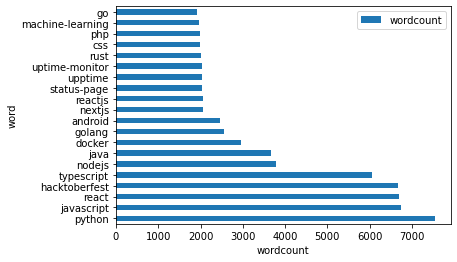

In [9]:
plot_barh(df1, 'word', 'wordcount', 20)

注意到，其中machine-learning是一个很有趣的topic

先构建临时表，将具有machine-learning主题的项目筛选出来

In [34]:
TEMP_TABLE_NAME = 'tmp_repo_ml_test'
drop_create_sql = '''
    DROP TABLE IF EXISTS {TEMP_TABLE_NAME};
    CREATE TABLE IF NOT EXISTS {TEMP_TABLE_NAME}
    (
      id                                                                      string,          
      owner                                                                   string,          
      ownerinfo_login                                                         string,          
      ownerinfo_typename                                                      string,          
      ownerinfo_name                                                          string,          
      ownerinfo_email                                                         string,          
      ownerinfo_description                                                   string,          
      ownerinfo_location                                                      string,          
      ownerinfo_websiteurl                                                    string,          
      ownerinfo_repositories_totalcount                                       int,          
      ownerinfo_memberswithrole_totalcount                                    int,          
      name                                                                    string,          
      license                                                                 string,          
      codeofconduct                                                           string,          
      createdat                                                               datetime,        
      updatedat                                                               datetime,        
      pushedat                                                                datetime,        
      isfork                                                                  boolean,         
      description                                                             string,          
      language                                                                string,          
      starcount                                                               int,           
      stars                                                                   string,          
      watchcount                                                              int,           
      forkcount                                                               int,           
      directforkcount                                                         int,           
      forks                                                                   string,          
      branchcount                                                             int,           
      defaultbranchname                                                       string,          
      defaultbranchcommitcount                                                int,           
      releasecount                                                            int,           
      topics                                                                  string,          
      issues                                                                  string,          
      pulls                                                                   string,          
      contributors                                                            string        
    );
'''.format(
    TEMP_TABLE_NAME=TEMP_TABLE_NAME
)
o.execute_sql(drop_create_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})

<Instance 20220529062759367gfs1l4pr2>

In [38]:
insert_sql = '''
    INSERT INTO {TEMP_TABLE_NAME}
    SELECT * FROM ods_github_repos
    WHERE topics like '%machine-learning%';
'''.format(
    TEMP_TABLE_NAME=TEMP_TABLE_NAME
)
o.execute_sql(insert_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})

<Instance 20220529063153615gwqe2i5s2>

In [39]:
test_sql = '''
    SELECT * FROM {TEMP_TABLE_NAME};
'''.format(
    TEMP_TABLE_NAME=TEMP_TABLE_NAME
)
with o.execute_sql(test_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader:
    df2 = reader.to_pandas()
df2 = df2.drop_duplicates()

### 探索顶级项目有哪些

#### 最近更新的项目

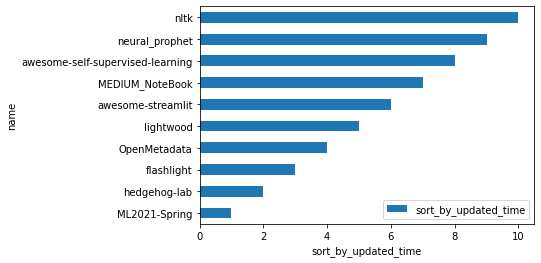

In [41]:
df3 = df2.sort_values('updatedat',ascending=False)[:100].reset_index(drop=True)
df3['sort_by_updated_time'] = list(df3.index+1)
plot_barh(df3, 'name', 'sort_by_updated_time', 10)

可见ML2021-Spring等项目最近仍然在更新；

#### 持续时间最长的项目（update和push取时间最近的）

In [42]:
def return_recent():
    tmp_list = []
    for i in range(len(df2)):
        if df2['pushedat'][i]>df2['updatedat'][i]:
            timedelta = df2['pushedat'][i] - df2['createdat'][i]
            timestr = str(timedelta)
            timedays = int(timestr.split(' ')[0])
            tmp_list.append(timedays)
        else:
            timedelta = df2['updatedat'][i] - df2['createdat'][i]
            timestr = str(timedelta)
            timedays = int(timestr.split(' ')[0])
            tmp_list.append(timedays)
    return tmp_list

In [43]:
df2['last_time'] = pd.DataFrame(return_recent())

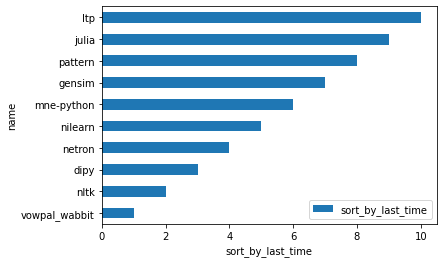

In [44]:
df4 = df2.sort_values('last_time',ascending=False)[:100].reset_index(drop=True)
df4['sort_by_last_time'] = list(df4.index+1)
plot_barh(df4, 'name', 'sort_by_last_time', 10)

可见vowpal_wabbit是持续时间最长的项目；

#### STAR的数量

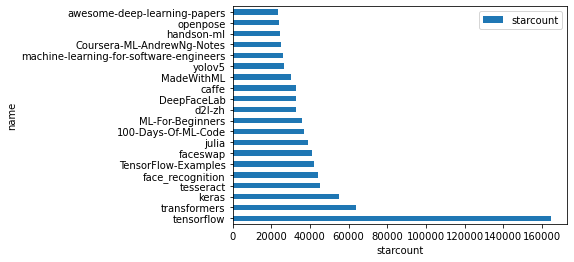

In [45]:
plot_barh(df2.sort_values('starcount',ascending=False), 'name', 'starcount', 20)

可见tensorflow是star最多的项目；

#### 关注的数量

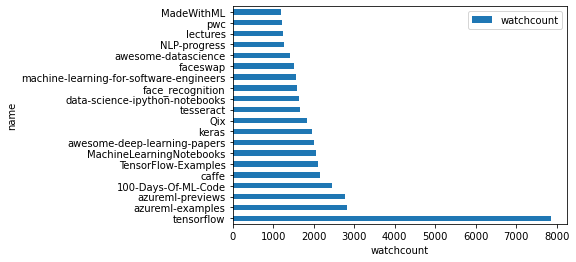

In [46]:
plot_barh(df2.sort_values('watchcount',ascending=False), 'name', 'watchcount', 20)

可见tensorflow被关注的人数最多；

#### 被FORK的数量

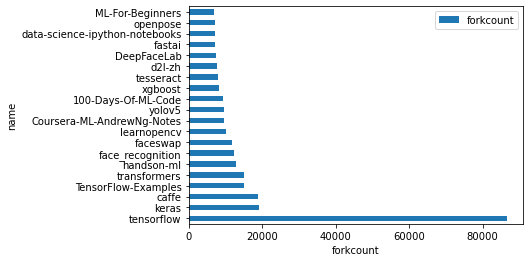

In [47]:
plot_barh(df2.sort_values('forkcount',ascending=False), 'name', 'forkcount', 20)

可见tensorflow被fork的数量最多；

#### 被直接FORK的数量

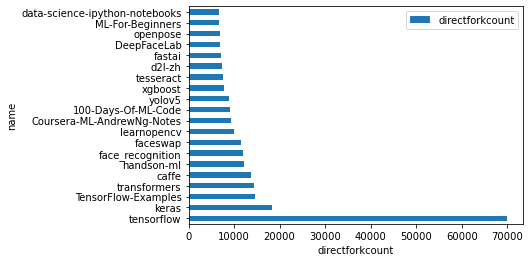

In [48]:
plot_barh(df2.sort_values('directforkcount',ascending=False), 'name', 'directforkcount', 20)

可见tensorflow被直接fork的数量最多；

#### 分支数量

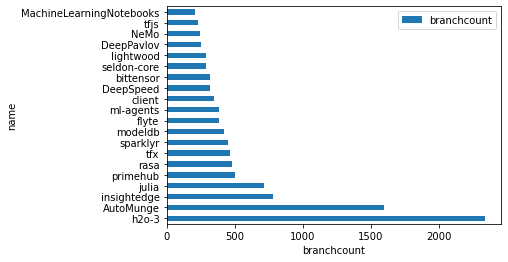

In [49]:
plot_barh(df2.sort_values('branchcount',ascending=False), 'name', 'branchcount', 20)

可见h2o-3分支数量最多；

#### 默认分支commit数量

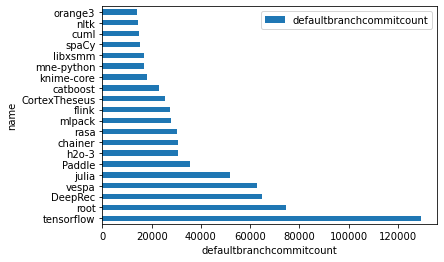

In [50]:
plot_barh(df2.sort_values('defaultbranchcommitcount',ascending=False), 'name', 'defaultbranchcommitcount', 20)

可见tensorflow默认分支commit数量最多；

#### 发布数量

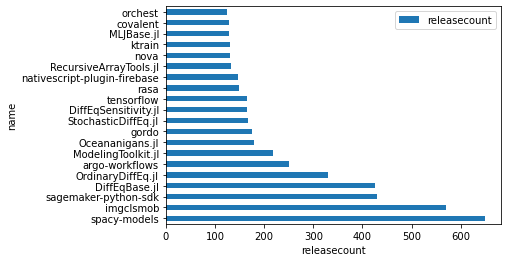

In [51]:
plot_barh(df2.sort_values('releasecount',ascending=False), 'name', 'releasecount', 20)

可见spacy-models发布数量最多；

#### 综合排序

In [52]:
df5 = df2.sort_values(by=['starcount','last_time','watchcount','forkcount','directforkcount','branchcount','defaultbranchcommitcount','releasecount'], ascending=False).reset_index(drop=True)

In [53]:
df6 = df5[df5['createdat'] >= '20150101']

In [56]:
explore_list = list(df6[:3]['name'])

### 探索Top3顶级项目生命周期

tensorflow创建于2015-11-07

owner为tensorflow

In [65]:
top1_explore_sql = '''
    SELECT * 
    FROM ods_github_log
    WHERE repo_name like 'tensorflow/tensorflow';
'''
with o.execute_sql(top1_explore_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader:
    df7 = reader.to_pandas()

transformers创建于2018-10-29

owner为huggingface

In [66]:
top2_explore_sql = '''
    SELECT * 
    FROM ods_github_log
    WHERE repo_name like 'huggingface/transformers';
'''
with o.execute_sql(top2_explore_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader:
    df8 = reader.to_pandas()

keras创建于2015-03-28

owner为keras-team

In [67]:
top3_explore_sql = '''
    SELECT * 
    FROM ods_github_log
    WHERE repo_name like 'keras-team/keras';
'''
with o.execute_sql(top3_explore_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader:
    df9 = reader.to_pandas()

MemberEvent <-> added AddMember
ReleaseEvent <-> published PublishRelease
WatchEvent <-> started StartWatch
IssuesEvent <- labeled, reopened, closed, opened LabelIssue ReopenIssue CloseIssue OpenIssue
PullRequestEvent <- reopened, closed, opened ReopenPullRequest ClosePullRequest OpenPullRequest

reopened -> IssuesEvent, PullRequestEvent
closed -> IssuesEvent, PullRequestEvent
opened -> IssuesEvent, PullRequestEvent
created -> IssueCommentEvent, PullRequestReviewCommentEvent CreateIssueComment CreatePullRequestReviewComment

In [165]:
def draw_pic(df):
    df_1 = df.groupby(['type','action','pt'])['id'].count().reset_index(name='count')
    df_1['type_action'] = df_1[['type', 'action']].agg('_'.join, axis=1)
    df_1['pt'] = pd.to_datetime(df_1['pt'])
    sns.set_context({'figure.figsize':[20, 20]})
    sns.lineplot(data=df_1, x='pt', y='count', hue='type_action')

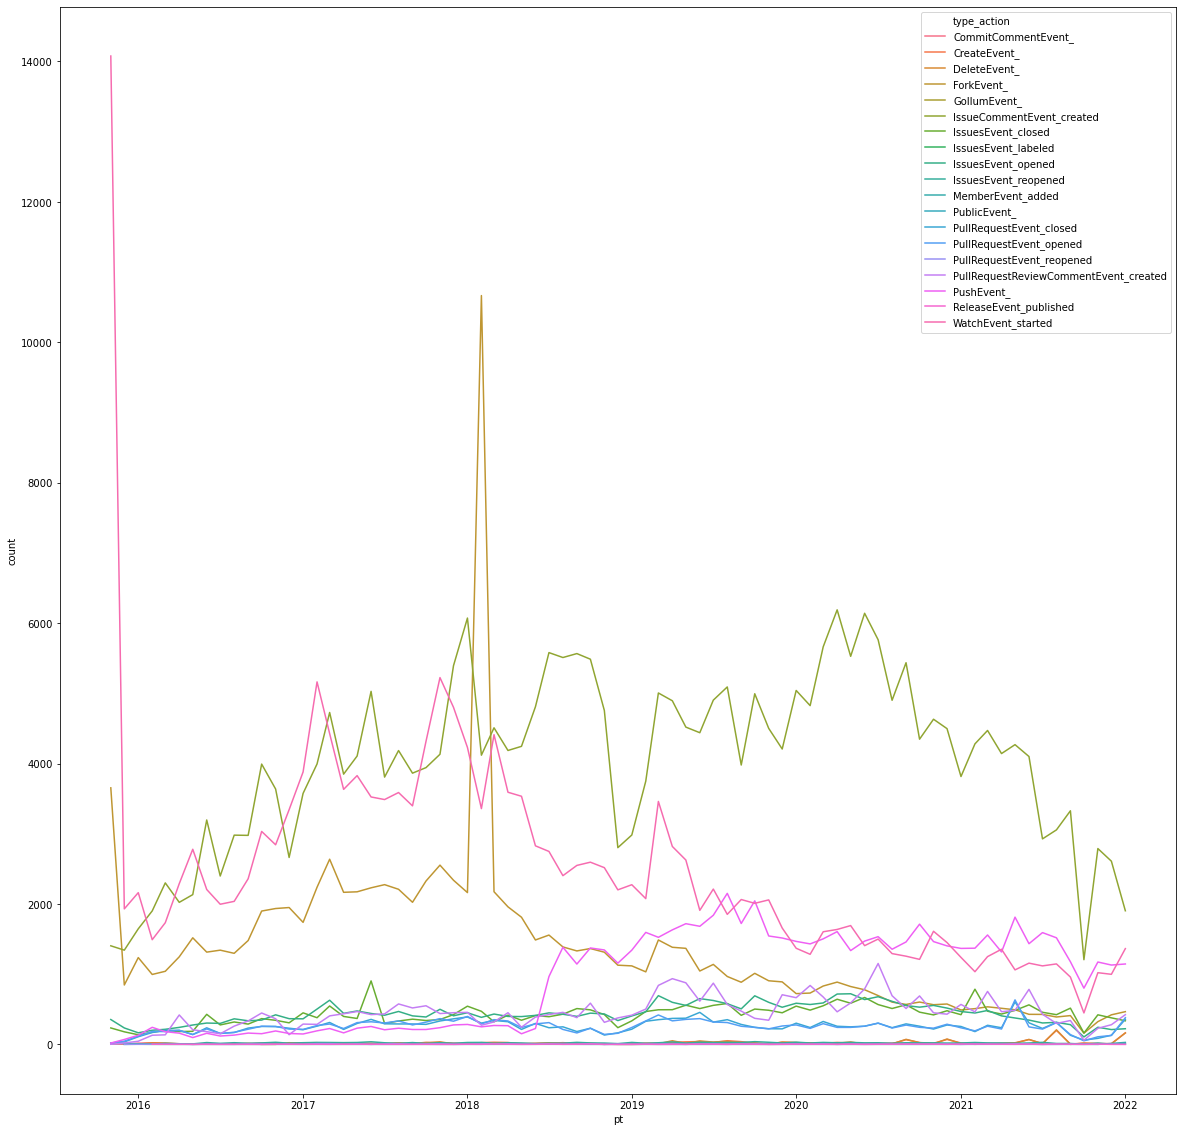

In [166]:
draw_pic(df7)

可见tensorflow项目在建立之初就备受关注，然后经过了一段时间的增长，在2019年之后新增关注人数逐渐下降；

IssueCommentEvent一直在逐步增加，但在2019年左右新增数量突然下降，之后又逐步增加并在2020年初达到新高，又在2021年年中的时候突然下降；

Fork事件的数量在建立之初已经有一部分人对该项目Fork并进行开发，后来在2018年初突然骤升，又在之后突然骤降，并逐步下降；

值得关注的是从2018年初开始PushEvent开始逐步增加，之前的数量较少，应该是更多开发人员加入导致的；

所以tensorflow项目的生命周期可以从2018年初这个点开始划分。

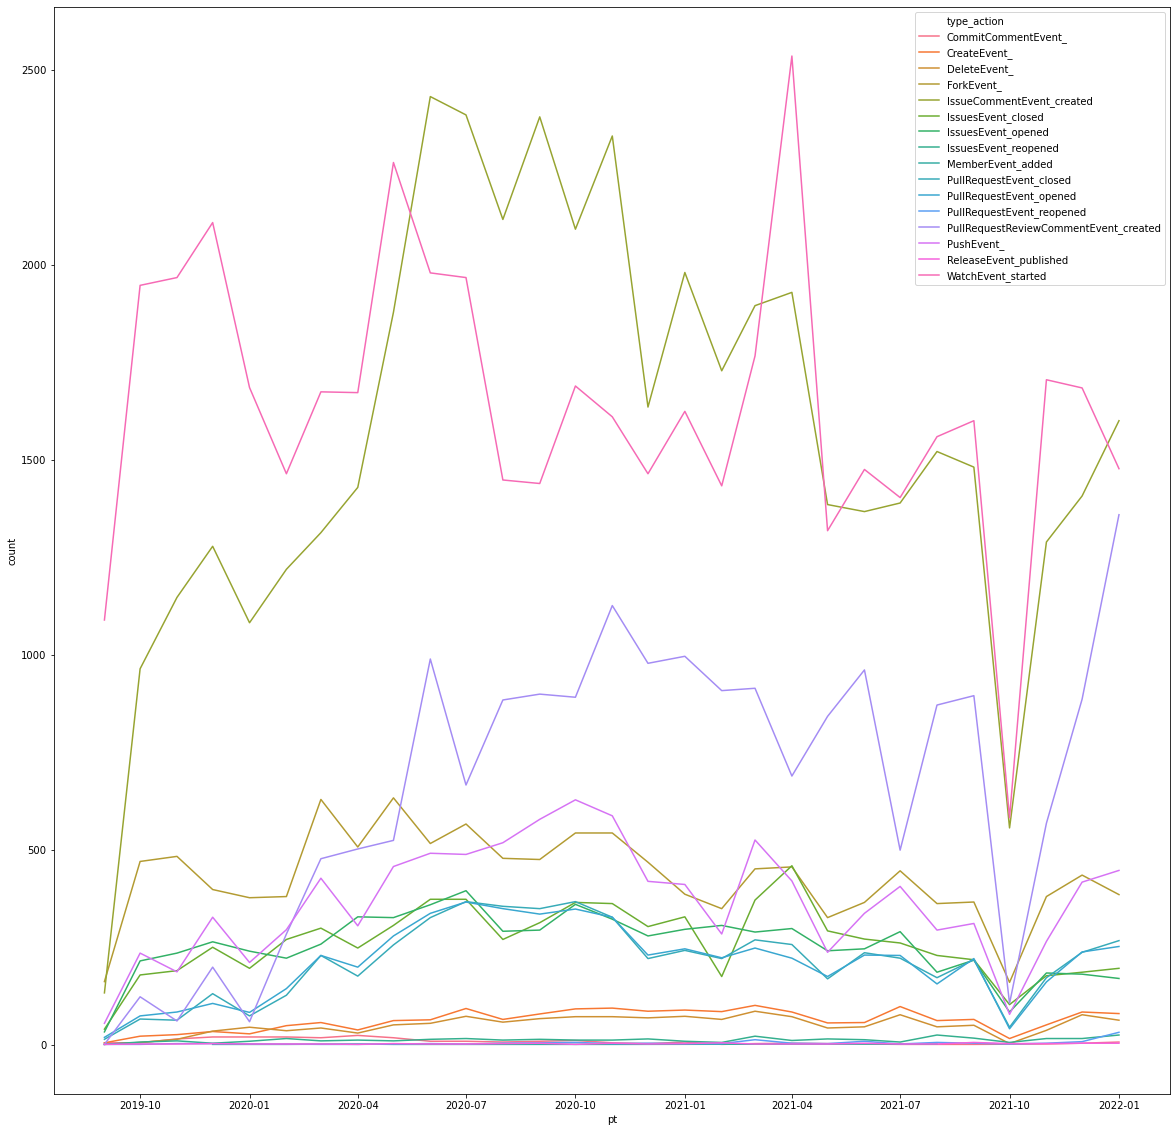

In [175]:
draw_pic(df8)

transformers项目在2018年10月末建立之后，一开始关注的人数不多，在2019年10月份大致一年的时间里开始发展；

项目一直到2020年7月份左右都发展十分迅速，之后到2021年5月份左右都属于平稳发展期；

之后在2021年10月份所有数据都骤降，不确定是否是数据异常，之后又保持在另一个数值较低的平稳发展期；

所以transformers项目的生命周期有两个节点，2020年5月份以及2021年5月份。

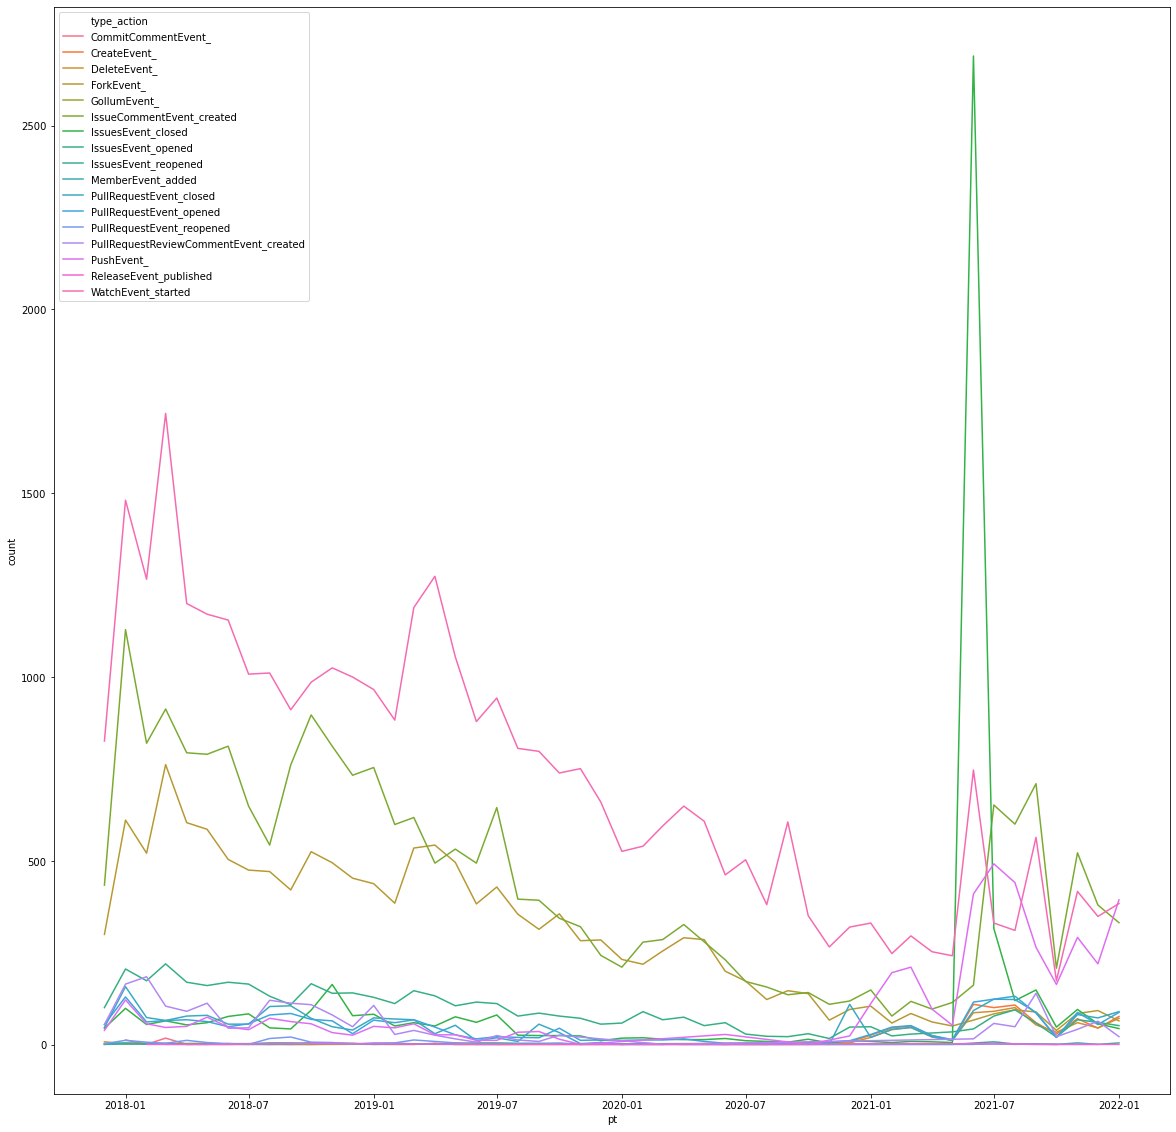

In [168]:
draw_pic(df9)

keras项目的事件趋势较为明显，从项目初步发展数值增加到2018年3月份，之后新增数量便逐步递减，到2019年5月份有所动荡，之后便一直下降到2021年7月份，之后又小幅度上涨到一定水平；

而且在将近2021年6月份左右时Fork事件的数量才逐步上升；

所以keras项目的生命周期节点应为2021年6月份。

#### 经过上述项目生命周期节点的分析，可见github中项目的主要事件为Watch、Fork以及IssueComment，主要能判断生命周期的事件是Push.

### 定义活跃度指标

In [179]:
WATCH_WEIGHT = 1
FORK_WEIGHT = 2
ISSUECOMMENT_WEIGHT = 1
TEMP_TABLE_NAME = 'tmp_repo_activity_m'

In [208]:
drop_create_sql = '''
    DROP TABLE IF EXISTS {TEMP_TABLE_NAME};
    CREATE TABLE IF NOT EXISTS {TEMP_TABLE_NAME}
    (
        repo_id STRING,
        repo_name STRING,
        watch_event_num DOUBLE,
        fork_event_num DOUBLE,
        issuecomment_event_num DOUBLE,
        push_event_num DOUBLE,
        score DOUBLE,
        pt STRING
    );
'''.format(
    TEMP_TABLE_NAME=TEMP_TABLE_NAME
)
o.execute_sql(drop_create_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})

<Instance 20220529164443520g8txk4pr2>

In [219]:
select_sql = '''
    INSERT INTO {TEMP_TABLE_NAME}
    SELECT 
        a.repo_id AS repo_id
        ,any_value(a.repo_name) AS repo_name
        ,MAX(wc.watch_event_num)
        ,MAX(fc.fork_event_num)
        ,MAX(icc.issuecomment_event_num)
        ,MAX(pc.push_event_num)
        ,round(sum(sqrt(((({WATCH_WEIGHT} * nvl(wc.watch_event_num, 0)) 
                        + ({FORK_WEIGHT} * nvl(fc.fork_event_num, 0))) 
                        + ({ISSUECOMMENT_WEIGHT} * nvl(icc.issuecomment_event_num, 0))))),2) AS score
        ,a.pt
    FROM
    (
        SELECT 
            repo_id
            ,repo_name
            ,pt
        FROM    ods_github_log
        WHERE   repo_id != '0'
                AND repo_name IN (
                    SELECT CONCAT(owner,'/',name) as n
                    FROM ods_github_repos
                    WHERE topics like '%machine-learning%'
                    )
        GROUP BY repo_id
                 ,repo_name
                 ,pt
    ) a
    FULL JOIN
    (
        SELECT
            repo_id
            ,any_value(repo_name) AS repo_name
            ,pt
            ,COUNT(*) AS watch_event_num
        FROM ods_github_log
        WHERE   (type = 'WatchEvent') AND (action = 'started')
                AND repo_id != '0'
                AND repo_name IN (
                    SELECT CONCAT(owner,'/',name) as n
                    FROM ods_github_repos
                    WHERE topics like '%machine-learning%'
                    )
        GROUP BY
            repo_id
            ,repo_name
            ,pt
    ) AS wc ON a.repo_id=wc.repo_id AND a.pt=wc.pt
    FULL JOIN
    (
        SELECT
            repo_id
            ,any_value(repo_name) AS repo_name
            ,pt
            ,COUNT(*) AS fork_event_num
        FROM ods_github_log
        WHERE   (type = 'ForkEvent') AND (action = '')
                AND repo_id != '0'
                AND repo_name IN (
                    SELECT CONCAT(owner,'/',name) as n
                    FROM ods_github_repos
                    WHERE topics like '%machine-learning%'
                    )
        GROUP BY
            repo_id
            ,repo_name
            ,pt
    ) AS fc ON a.repo_id=fc.repo_id AND a.pt=fc.pt
    FULL JOIN
    (
        SELECT
            repo_id
            ,any_value(repo_name) AS repo_name
            ,pt
            ,COUNT(*) AS issuecomment_event_num
        FROM ods_github_log
        WHERE   (type = 'IssueCommentEvent') AND (action = 'created')
                AND repo_id != '0'
                AND repo_name IN (
                    SELECT CONCAT(owner,'/',name) as n
                    FROM ods_github_repos
                    WHERE topics like '%machine-learning%'
                    )
        GROUP BY
            repo_id
            ,repo_name
            ,pt
    ) AS icc ON a.repo_id=icc.repo_id AND a.pt=icc.pt
    FULL JOIN
    (
        SELECT
            repo_id
            ,any_value(repo_name) AS repo_name
            ,pt
            ,COUNT(*) AS push_event_num
        FROM ods_github_log
        WHERE   (type = 'PushEvent') AND (action = '')
                AND repo_id != '0'
                AND repo_name IN (
                    SELECT CONCAT(owner,'/',name) as n
                    FROM ods_github_repos
                    WHERE topics like '%machine-learning%'
                    )
        GROUP BY
            repo_id
            ,repo_name
            ,pt
    ) AS pc ON a.repo_id=pc.repo_id AND a.pt=pc.pt
    GROUP BY
    a.repo_id
    ,a.repo_name
    ,a.pt
    HAVING a.pt>='20150101';
'''.format(
    TEMP_TABLE_NAME = TEMP_TABLE_NAME
    ,WATCH_WEIGHT = WATCH_WEIGHT
    ,FORK_WEIGHT = FORK_WEIGHT
    ,ISSUECOMMENT_WEIGHT = ISSUECOMMENT_WEIGHT
)
o.execute_sql(select_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})

In [221]:
test_sql = '''
    SELECT * FROM {TEMP_TABLE_NAME};
'''.format(
    TEMP_TABLE_NAME=TEMP_TABLE_NAME
)
with o.execute_sql(test_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader:
    df_w = reader.to_pandas()
df_w = df_w.drop_duplicates()

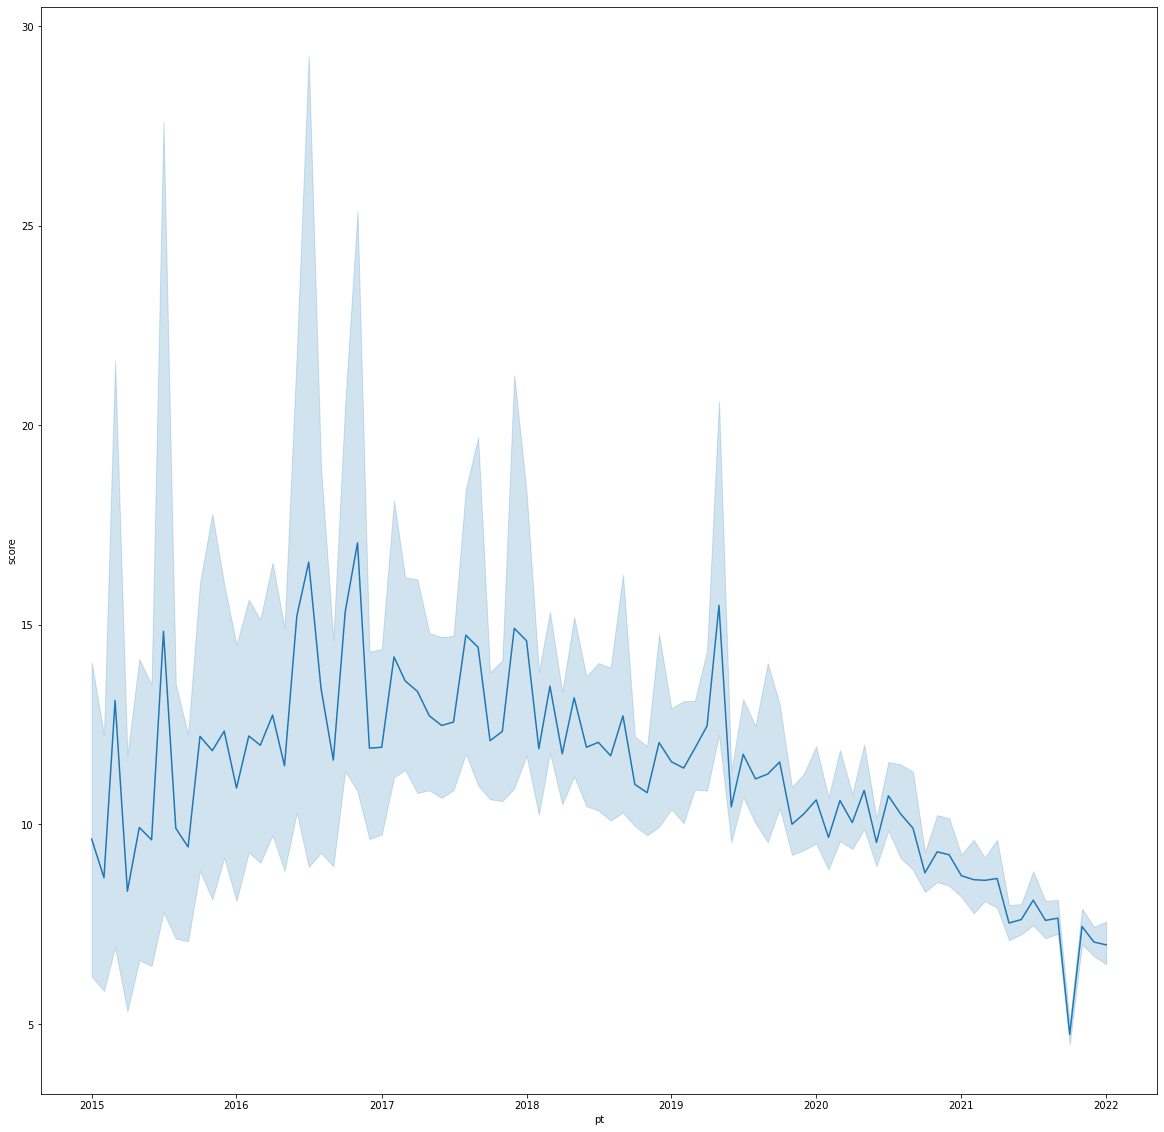

In [233]:
df_w['pt'] = pd.to_datetime(df_w['pt'])
sns.set_context({'figure.figsize':[20, 20]})
sns.lineplot(data=df_w, x='pt', y='score')

In [197]:
# select_sql = '''
#     SELECT *
#     FROM temp_dynamic_activities_test
#     WHERE repo_name IN (
#               SELECT CONCAT(owner,'/',name) as n
#               FROM ods_github_repos
#               WHERE topics like '%machine-learning%'
#               )
# '''
# with o.execute_sql(select_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader:
#     df_2 = reader.to_pandas()

### 根据活跃度指标聚类

In [247]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from math import radians, sin, cos, asin, sqrt

In [250]:
data = df_w[['pt','score']][1:]

In [253]:
data = data.sort_values('pt')

In [254]:
encoder= LabelEncoder().fit(data['pt'])
data['pt'] = encoder.transform(data['pt'])

In [255]:
data

,pt,score
122,0,16.22
28339,0,5.20
28467,0,13.27
1739,0,0.00
1688,0,6.48
...,...,...
26454,84,1.41
26452,84,8.06
42089,84,3.32
26430,84,10.10


In [ ]:
db = DBSCAN(eps=20, min_samples=100, metric='euclidean').fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = list(set(labels))[:3]
colors = ['r', 'b', 'g', 'y', 'c', 'm']
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
    class_member_mask = (labels == k)
    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy['pt'], xy['score'], 'o', markerfacecolor=col, markeredgecolor='w', markersize=10)
    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy['pt'], xy['score'], 'o', markerfacecolor=col, markeredgecolor='w', markersize=10)
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()